## Imports

In [2]:
import sys
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms, models
import torch
import random
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

sys.path.insert(0, '../src')

import models
import util

torch.cuda.empty_cache()

# Training playground

### Declarations

In [2]:
train_dir = "../data/train"
test_dir = "../data/test"

patch_size = 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# create train and test dataset
train_dataset = models.ImageDataset(train_dir, mode="train")
test_dataset = models.ImageDataset(test_dir, mode="test")

# batch size
batch_size = 64

# create train and test dataloader
training_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True, num_workers=4)
testing_data_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True, pin_memory=True, drop_last=False)

# model declaration and hyperparameters
model = models.DnCNN().to(device)
criterion = nn.L1Loss().to(device)
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

### Train

In [4]:
def train(epoch):
    epoch_loss = 0
    for iteration, data in enumerate(training_data_loader):
        optimizer.zero_grad()
        
        input = data['L'].cuda()
        target = data['H'].cuda()

        output = model(input)

        loss = criterion(output, target)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        # print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))

### Validate

In [5]:
def validate(epoch):
    avg_psnr = 0
    model.eval()
    with torch.no_grad():
        for data in testing_data_loader:
            input = data['L'].cuda()
            target = data['H'].cuda()

            output = model(input)
            
            psnr = util.calcPSNR(output, target)
            avg_psnr += psnr

        images = ['../data/test/253027.jpg','../data/test/102061.jpg','../data/test/101085.jpg']
        sigmas = [25,12.5,0]
        # zoomParams = [
        #     util.ZoomParams(xpos=150, ypos=60, size=80),
        #     util.ZoomParams(xpos=40, ypos=100, size=80),
        #     util.ZoomParams(xpos=40, ypos=100, size=80)
        # ]
        util.makeSamplePlot(model, images, sigmas, f"DnCNN[R] - Epoch {epoch}", ['Sigma 25', 'Sigma 12.5','Sigma 0'], figLocation=f"../figures/dncnn-r_epochs/dncnn-r_epoch_{epoch}.png")
        # img_H = np.asarray(Image.open('../data/test/253027.jpg'))
        # img_H = util.uint2float(img_H)
        # img_L = np.copy(img_H)
        # img_L += np.random.normal(0, 25/255.0, img_L.shape)

        # img_L = util.float2tensor(img_L)
        # img_H = util.float2tensor(img_H)
        
        # img_E = model(img_L.unsqueeze(0).cuda())

        # HL_psnr = util.calcPSNR(img_H, img_L)
        # HE_psnr = util.calcPSNR(img_H, img_E.cpu())
        # img_L = util.tensor2uint(img_L)
        # img_E = util.tensor2uint(img_E.squeeze(0))

        # fig, ax = plt.subplots(1,3)
        # fig.suptitle(f"DnCNN - Epoch {epoch}", fontsize=28)
        # fig.set_figheight(6)
        # fig.set_figwidth(20)
        # fig.subplots_adjust(wspace=0, hspace=0)
        # for axis in ax:
        #     axis.set_xticklabels([])
        #     axis.set_yticklabels([])
            
        # ax[0].imshow(transforms.ToPILImage()(img_H))
        # ax[0].set_xlabel("Reference image", fontsize=14)
        # ax[1].imshow(img_L)
        # ax[1].set_xlabel(f"PSNR to ref.: {HL_psnr}", fontsize=14)
        # ax[2].imshow(img_E)
        # ax[2].set_xlabel(f"PSNR to ref.: {HE_psnr}", fontsize=14)
        # plt.savefig(f'../figures/dncnn_epoch_{epoch}.png', facecolor="w")

    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

### Save model

In [6]:
def save_checkpoint(state):
    model_out_path = "../models/dncnn-r/dncnn_epoch_{}.pth".format(epoch)
    torch.save(state, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

### Training loop

In [2]:
num_epochs = 100000
for epoch in range(1, num_epochs + 1):
    train(epoch)
    if epoch % 500 == 0:
      validate(epoch)
      save_checkpoint({
          'epoch': epoch + 1,
          'arch': model,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
      })

NameError: name 'train' is not defined

In [2]:
torch.cuda.empty_cache()

img_H = np.asarray(Image.open('../data/real/coast.JPG'))

img_H = util.uint2float(img_H)

img_H = util.float2tensor(img_H)

with torch.no_grad():
    model_test = models.DnCNN()
    model_test.load_state_dict(torch.load("../models/dncnn_epoch_4000.pth")['state_dict'])
    model_test.eval()
    model_test.cpu()
    img_E = model_test(img_H.unsqueeze(0).cpu())
    # test = patch_L.unsqueeze(0)
    # output = model_test(test.cuda())
# img_H = util.tensor2uint(img_H)
# img_E = util.tensor2uint(img_E.squeeze(0))

# fig, ax = plt.subplots(1,2)
# fig.set_figheight(50)
# fig.set_figwidth(150)
# fig.subplots_adjust(wspace=0, hspace=0)
# for axis in ax:
#     axis.set_xticklabels([])
#     axis.set_yticklabels([])
    
# ax[0].imshow(img_H)
# ax[1].imshow(img_E)
# # plt.show()
# plt.savefig('coast_hi.png')

FileNotFoundError: [Errno 2] No such file or directory: '../models/dncnn_epoch_4500.pth'

### Plot experiments

In [3]:
model_test = models.DnCNN()
model_test.load_state_dict(torch.load("../models/dncnn-r/dncnn_epoch_25000.pth")['state_dict'])

<All keys matched successfully>

ValueError: too many values to unpack (expected 2)

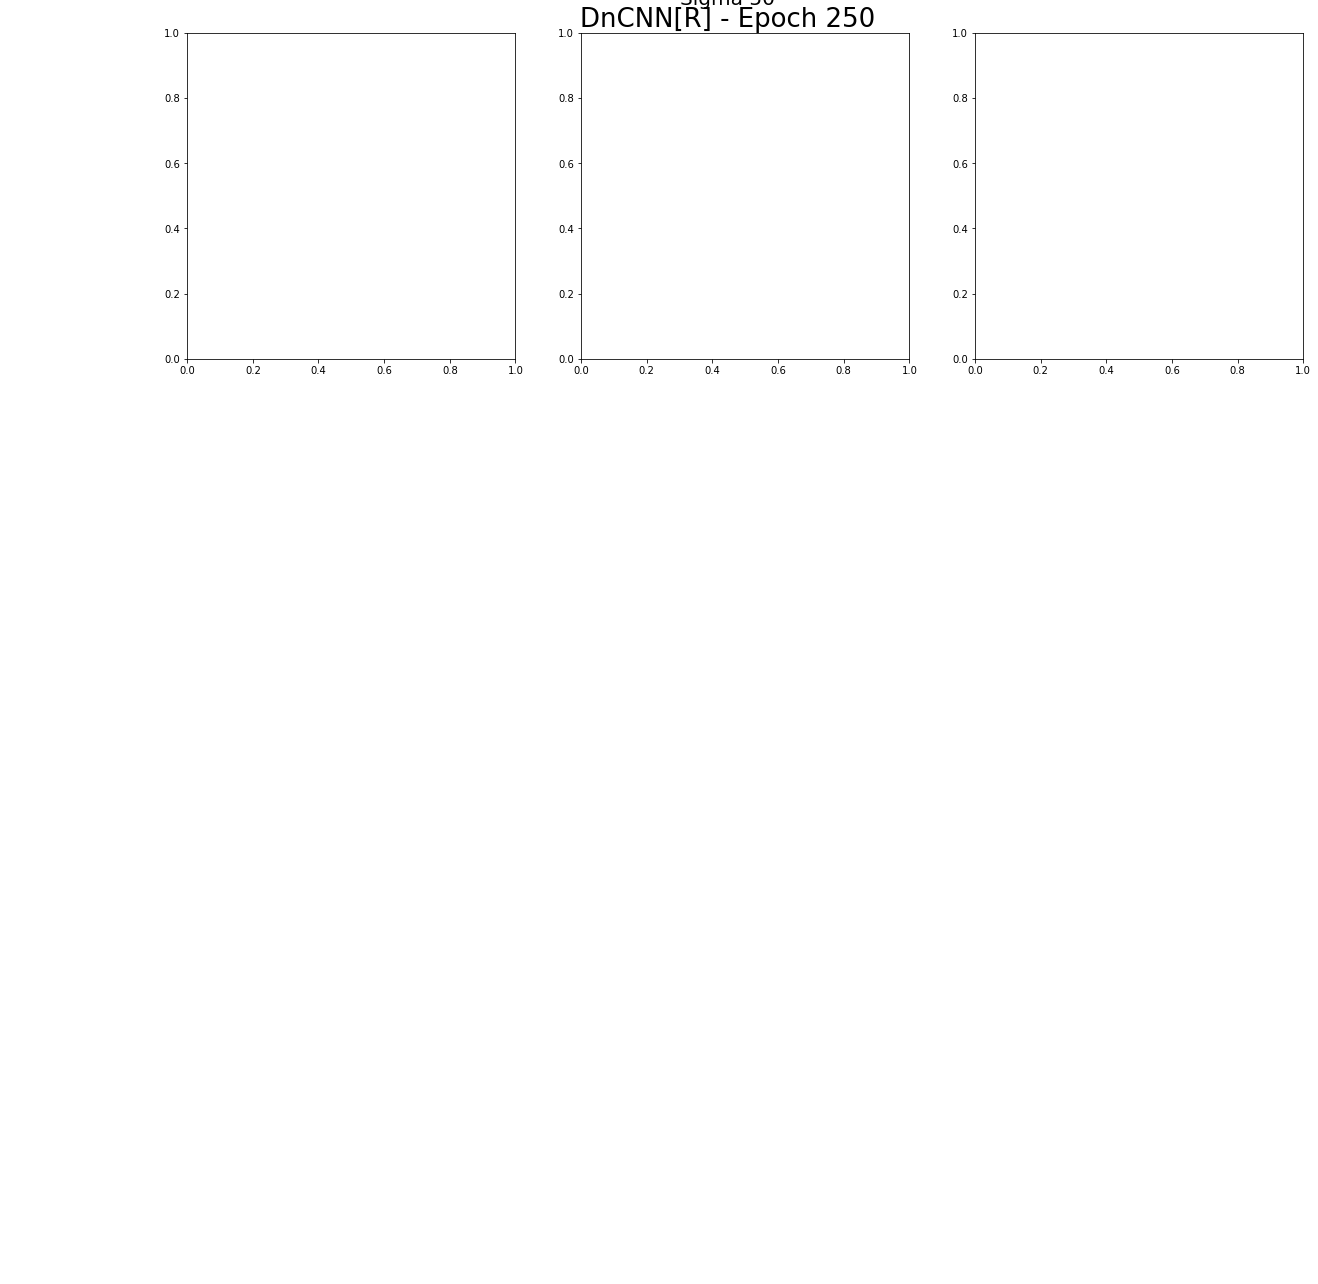

In [3]:
images = ['../data/test/253027.jpg','../data/test/102061.jpg','../data/test/101085.jpg']
sigmas = [25,50,70]
# zoomParams = [
#     util.ZoomParams(xpos=150, ypos=60, size=80),
#     util.ZoomParams(xpos=40, ypos=100, size=80),
#     util.ZoomParams(xpos=40, ypos=100, size=80)
# ]
model_test.eval()
model_test.cuda()
util.makeSamplePlot(model_test, images, sigmas, "DnCNN[R] - Epoch 250", ['Sigma 50', 'Sigma 25','Sigma 0'])

# Triple plot

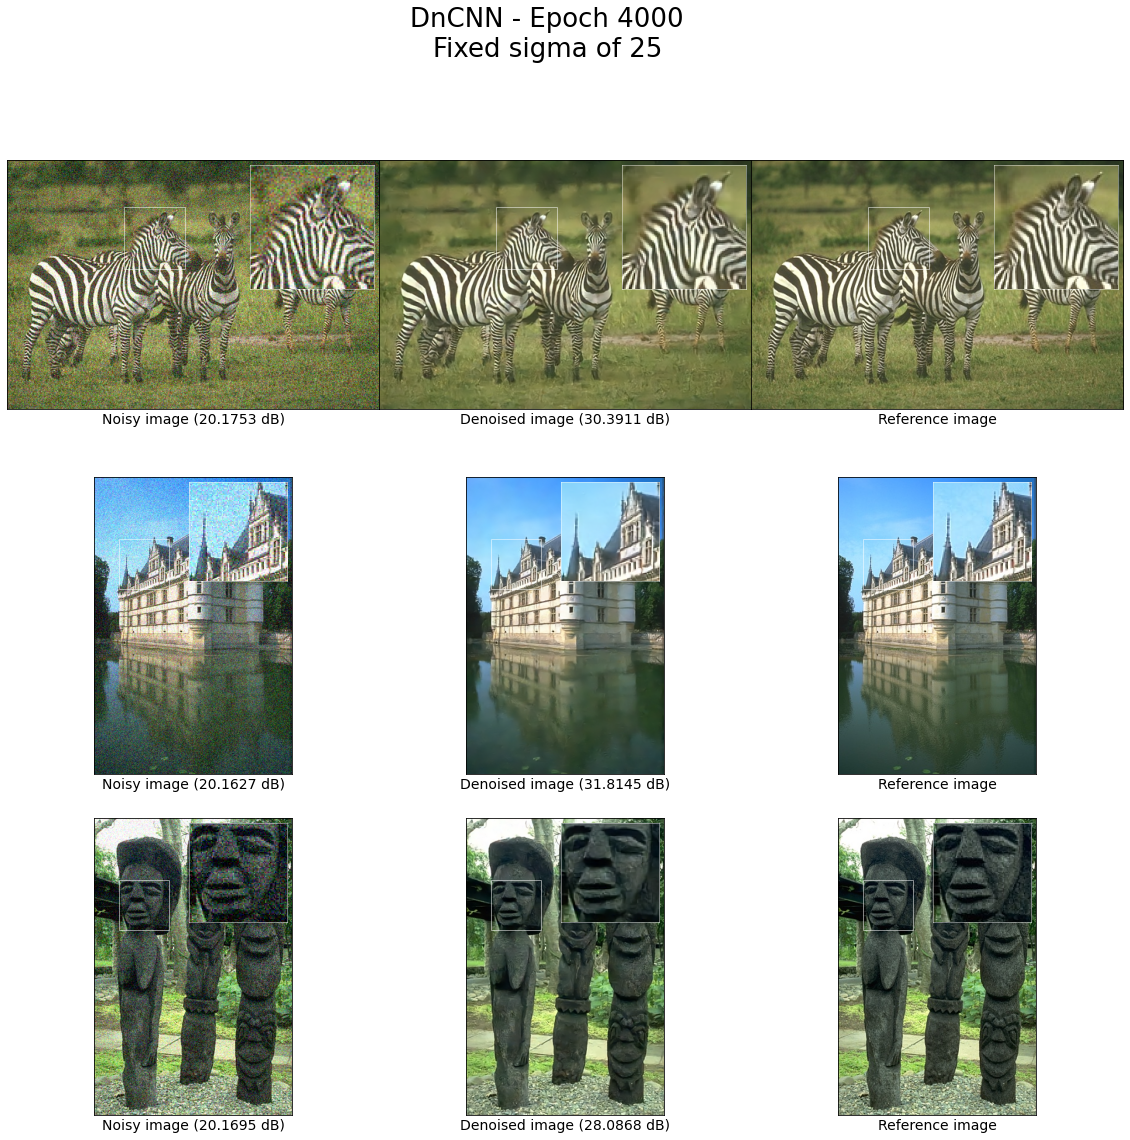

In [5]:
img_H = np.asarray(Image.open('../data/test/BSD300/253027.jpg'))
img_H = util.uint2float(img_H)
img_L = np.copy(img_H)
img_L += np.random.normal(0, 25/255.0, img_L.shape)

img_L = util.float2tensor(img_L)
img_H = util.float2tensor(img_H)

with torch.no_grad():
    model_test.eval()
    model_test.cuda()
    img_E = model_test(img_L.unsqueeze(0).cuda())

HL_psnr = util.calcPSNR(img_H, img_L)
HE_psnr = util.calcPSNR(img_H, img_E.cpu())
img_H = util.tensor2uint(img_H)
img_L = util.tensor2uint(img_L)
img_E = util.tensor2uint(img_E.squeeze(0))

fig, ax = plt.subplots(3,3)
fig.suptitle(f"DnCNN - Epoch 4000\nFixed sigma of 25", fontsize=26)
fig.set_figheight(18)
fig.set_figwidth(20)
fig.subplots_adjust(hspace=.15, wspace=0)
zoomParams = util.ZoomParams(xpos=150, ypos=60, size=80)
axes = ax[0]
imgs = [img_L, img_E, img_H]
labels = [
    f"Noisy image ({HL_psnr:.4f} dB)",
    f"Denoised image ({HE_psnr:.4f} dB)",
    "Reference image"
]
util.plotRow(axes, imgs, labels, zoomParams)

img_H = np.asarray(Image.open('../data/test/BSD300/102061.jpg'))
img_H = util.uint2float(img_H)
img_L = np.copy(img_H)
img_L += np.random.normal(0, 25/255.0, img_L.shape)

img_L = util.float2tensor(img_L)
img_H = util.float2tensor(img_H)

with torch.no_grad():
    model_test.eval()
    model_test.cuda()
    img_E = model_test(img_L.unsqueeze(0).cuda())

HL_psnr = util.calcPSNR(img_H, img_L)
HE_psnr = util.calcPSNR(img_H, img_E.cpu())
img_H = util.tensor2uint(img_H)
img_L = util.tensor2uint(img_L)
img_E = util.tensor2uint(img_E.squeeze(0))


zoomParams.xpos = 40
zoomParams.ypos = 100
zoomParams.size = 80
axes = ax[1]
imgs = [img_L, img_E, img_H]
labels = [
    f"Noisy image ({HL_psnr:.4f} dB)",
    f"Denoised image ({HE_psnr:.4f} dB)",
    "Reference image"
]
util.plotRow(axes, imgs, labels, zoomParams)


img_H = np.asarray(Image.open('../data/test/BSD300/101085.jpg'))
img_H = util.uint2float(img_H)
img_L = np.copy(img_H)
img_L += np.random.normal(0, 25/255.0, img_L.shape)

img_L = util.float2tensor(img_L)
img_H = util.float2tensor(img_H)

with torch.no_grad():
    model_test.eval()
    model_test.cuda()
    img_E = model_test(img_L.unsqueeze(0).cuda())

HL_psnr = util.calcPSNR(img_H, img_L)
HE_psnr = util.calcPSNR(img_H, img_E.cpu())
img_H = util.tensor2uint(img_H)
img_L = util.tensor2uint(img_L)
img_E = util.tensor2uint(img_E.squeeze(0))

xpos = 40
ypos = 100
size = 80
axes = ax[2]
imgs = [img_L, img_E, img_H]
labels = [
    f"Noisy image ({HL_psnr:.4f} dB)",
    f"Denoised image ({HE_psnr:.4f} dB)",
    "Reference image"
]
util.plotRow(axes, imgs, labels, zoomParams)


plt.savefig(f'../figures/dncnn_tests/dncnn_epoch_4000_zooms.png', facecolor="w", bbox_inches='tight', dpi=200)


    

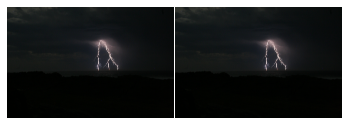

In [10]:
torch.cuda.empty_cache()

img_H = np.asarray(Image.open('../data/real/lightning.JPG'))

patches_E = util.patchify(img_H, size=128)
patches_H = patches_E.copy()
with torch.no_grad():
    model_test = models.DnCNN()
    model_test.load_state_dict(torch.load("../models/dncnn-r/dncnn_epoch_25000.pth")['state_dict'])
    model_test.eval()
    model_test.cuda()
    for row in range(patches_E.shape[0]):
        for column in range(patches_E.shape[1]):
            output = model_test(util.uint2tensor(patches_E[row, column]).unsqueeze(0).cuda())
            patches_E[row, column] = util.tensor2uint(output).squeeze()
    # for patch in patches_E.reshape((-1, *patches_E.shape[2:])):
    #     output = model_test(util.uint2tensor(patch).unsqueeze(0).cuda())
    #     # patch = util.tensor2uint(output).squeeze()
    #     # patch = np.zeros((256,256,3))
    #     print(patches_E[patch])
util.makePlot([util.unpatchify(patches_H), util.unpatchify(patches_E) ], savePath="../figures/dncnn-r_tests/lightning_patched_128.png")

14.98918532300836
28.92274857672646


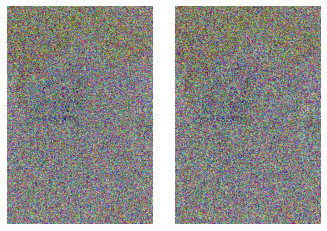

In [ ]:
noisy = np.asarray(Image.open("../data/bench/102061_noisy.png"))
estimate = np.asarray(Image.open("../data/bench/102061_dncnn_E.png"))
high = np.asarray(Image.open("../data/bench/102061_H.png"))


print(util.calcPSNR(util.uint2tensor(noisy), util.uint2tensor(high)))
print(util.calcPSNR(util.uint2tensor(high), util.uint2tensor(estimate)))

util.makePlot([noisy - estimate, noisy - high], savePath="dncnn_ref.png")